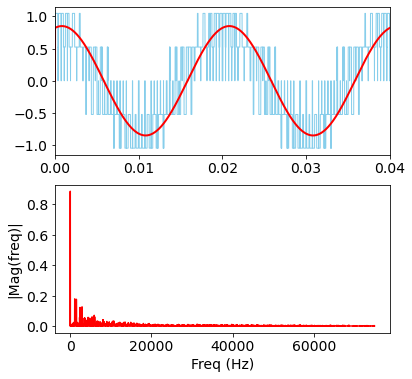

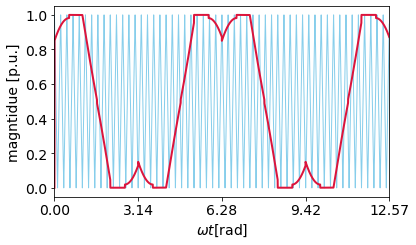

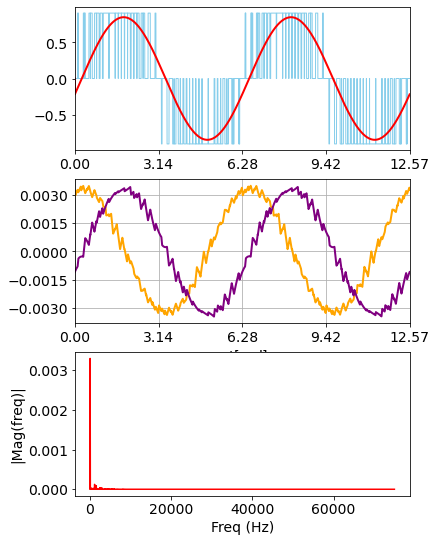

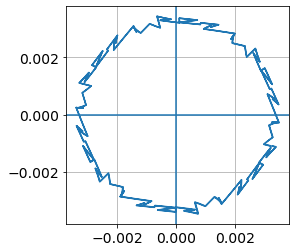

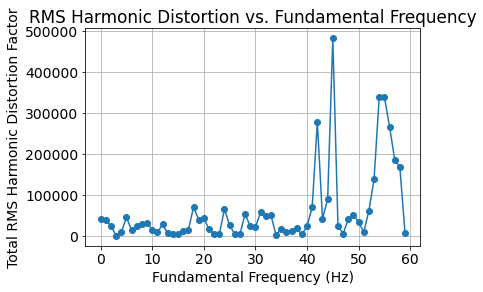

In [1]:
import numpy as np
from numpy import math,  cos, sin, pi,fft,arange,transpose
from pylab import figure, clf, plot, xlabel, ylabel, xlim, ylim, title, grid, axes, show,subplot,close
import matplotlib.pyplot as pl
from scipy.fftpack import fft
from scipy.integrate import odeint, quad

%matplotlib inline


cycles=2  #number of fundamental cycles
maxcount=1027.0#timer count timer resolution 
pulsenumber=int(27) #number of samples in pwm
fs=3e3   #switching frequency is 3 kHz
Tsby2=1/(2*fs) #half period of the counter
mi=0.85 #modulation index

def spacevectortimes (vref, sectorangle, subcycleperiod):
    tl=vref*subcycleperiod*(math.sin(sectorangle)/math.sin(math.pi/3))
    tr=vref*subcycleperiod*(math.sin(math.pi/3-sectorangle)/math.sin(math.pi/3))
    tz=subcycleperiod-tl-tr
    return tl,tr,tz


#procedure to compute sector angle and the sector number 
def sectorchar(totalangle):
    sectornum=int(float(totalangle)/(math.pi/3))
    sectorangle=(float(totalangle)/(math.pi/3))-int(float(totalangle)/(math.pi/3))
    return sectornum, sectorangle


def calculate_rms_harmonic_distortion(vs_alpha, fundamental_frequency, fs):
    # Calculate the FFT of vs_alpha using scipy's fft function
    N = len(vs_alpha)
    Y = fft(vs_alpha)
    
    # Frequency resolution
    freq_resolution = fs / N
    
    # Frequency index corresponding to the fundamental frequency
    fundamental_freq_index = int(fundamental_frequency / freq_resolution)
    
    # Calculate the RMS harmonic distortion factor
    rms_distortion = np.sqrt(np.sum(np.abs(Y[fundamental_freq_index*2:]))**2) / np.abs(Y[fundamental_freq_index])
    
    return rms_distortion


def DPWM3(ta,tb,t0,Tsby2,sector,sectorangle):
    sectorhalf=int(float(sectorangle)/(math.pi/6))
    if sector==0:
         #sector onetimes 0-60 degrees
        if sectorhalf==0:
            tu=tb/Tsby2+ta/Tsby2
            tv=ta/Tsby2
            tw=0
        else:
            tu=1
            tv=1-tb/Tsby2
            tw= t0/Tsby2
    elif sector==1:
         #sector two 60--120 degrees
        if sectorhalf==0:
            tu=1-ta/Tsby2
            tv=1
            tw=t0/Tsby2
        else:
            tu=tb/Tsby2
            tv=ta/Tsby2+tb/Tsby2
            tw= 0   
    elif sector==2:
        #sector 3 120--180 degrees
        if sectorhalf==0:
            tu=0
            tv=1-(t0/Tsby2)
            tw=ta/Tsby2
        else:
            tu=t0/Tsby2
            tv=1
            tw=t0/Tsby2+ta/Tsby2
    elif sector==3:
        #sector 4 180--240 degrees
        if sectorhalf==0:
            tu=t0/Tsby2
            tv=(t0/Tsby2+tb/Tsby2)
            tw=1
        else:
            tu=0
            tv=tb/Tsby2
            tw= 1-t0/Tsby2     
    elif sector==4:
        #sector 5 240--300 degrees
        if sectorhalf==0:
            tu=ta/(Tsby2)
            tv=0
            tw=1-(t0/Tsby2)      
        else:
            tu=t0/Tsby2+ta/Tsby2
            tv=t0/Tsby2
            tw=1
    elif sector==5:
        #sector 6 300-360 degrees
        if sectorhalf==0:
            tu=1
            tv=t0/Tsby2
            tw=t0/Tsby2+tb/Tsby2
        else:
            tu=1-t0/Tsby2
            tv=0
            tw=tb/Tsby2

    return tu,tv,tw

def DPWM0(ta,tb,t0,Tsby2,sector):
        if sector==0:
            #sector onetimes 0-60 degrees
            tw=0
            tv=ta/Tsby2
            tu=ta/Tsby2+tb/Tsby2
            inistate=0
        elif sector==1:
            tu=t0/Tsby2+tb/Tsby2
            tv=1
            tw=t0/Tsby2
            inistate=1
            #sector two 60--120 degrees
        elif sector==2:
            #sector 3 120--180 degrees
            tv=1-(t0/Tsby2)
            tw=ta/Tsby2
            tu=0
            inistate=0
        elif sector==3:
            x=4
            tu=t0/Tsby2
            tv=(t0/Tsby2+tb/Tsby2)
            tw=1
            inistate=1
            #sector 4 180--240 degrees
        elif sector==4:
            x=5
            tw=1-(t0/Tsby2)
            tv=0
            tu=ta/(Tsby2)
            inistate=0
            #sector 5 240--300 degrees
        elif sector==5:
            x=6
            #sector 6 300-360 degrees
            tv=t0/Tsby2
            tw=1-ta/Tsby2
            tu=1
            inistate=1
        return tu,tv,tw,inistate

def calculate_rms_harmonic_distortion(vs_alpha, fundamental_frequency, fs):
   
    # Calculate the FFT of vs_alpha
    N = len(vs_alpha)
    Y = fft(vs_alpha)
    
    # Frequency resolution
    freq_resolution = fs / N
    
    # Frequency index corresponding to the fundamental frequency
    fundamental_freq_index = int(fundamental_frequency / freq_resolution)
    
    # Calculate the RMS harmonic distortion factor
    rms_distortion = np.sqrt(np.sum(np.abs(Y[fundamental_freq_index*2:]))**2) / np.abs(Y[fundamental_freq_index])
    
    return rms_distortion

def plotSpectrum(y,Fs):
 """
 Plots a Single-Sided Amplitude Spectrum of y(t)
 """
 n = len(y) # length of the signal
 k = np.arange(n)
 T = n/Fs
 frq = k/T # two sides frequency range
 frq = 50 * frq[:n // 2] 
#frq = 50*frq[range(int(n/2))] # one side frequency range
 frq[0]=50
 Y = fft(y)/n # fft computing and normalization
 Y = Y[:n // 2]
#Y = Y[range(int(n/2))]
 ##print(frq,abs(Y))
 plot(frq[:3000],2*abs(Y[:3000]),'r') # plotting the spectrum
 xlabel('Freq (Hz)')
 ylabel('|Mag(freq)|')


def main():
    
            timelist=[0]
            triawave=1 #starts with 1
            tria=[1]	# this is the current waveform
            pwm_a=[0]		# This vector is the pwm for phase a
            pwm_b=[0]   # This vector is pwm for phase b
            pwm_c=[0]   #This vector is pwm for phase c
            s_a=[0]
            s_b=[0]
            s_c=[0]
            t_u=[0]
            t_v=[0]
            t_w=[0]
            gamma=[0]
            vs_alpha=[0]
            vs_beta=[0]
            vs_zero=[0]
            vi_alpha=[0]
            vi_beta=[0]
            delv_alpha=[0]
            delv_beta=[0]
            anglelist=[0]	# this vector contains the x-values at which the pwm signal
            anglelist2=[0]

            ialpha_ini=0
            ibeta_ini=0
            ix1=[ialpha_ini,ibeta_ini]
            ix2r=[0.0032]
            ix2i=[-0.0011]
  
            i=0
    
            fundamental_frequencies = []  # Initialize an empty list
            total_rms_harmonic_distortion = []  # Initialize an empty list

        
          #for cycle in range(1,cycles)
            for ii in range (1,int(2*cycles*maxcount*pulsenumber)):
                    anglelist.append((ii/(2*maxcount*pulsenumber))*(2*math.pi))
                    #if anglelist[ii]<(2*math.pi):
                    timelist.append(anglelist[ii]*(0.02/(2*math.pi)))
                    anglelist2.append(anglelist2[ii-1]+(2*math.pi/(2*maxcount*pulsenumber)))
                    #anglet=(ii/(2*maxcount*pulsenumber))*2*math.pi
                                         
                    
                    if anglelist2[ii]>=(2*math.pi):
                            anglelist2[ii]=anglelist2[ii]-(2*math.pi)
                    else:
                            anglelist2[ii]=anglelist2[ii]
            
                    angle=anglelist2[ii]        
                    
                
                    sectortt,secangle=sectorchar(angle)
                    
    
                    
                    ta,tb,t0=spacevectortimes(mi,secangle,Tsby2)
                    
                    
                    gamma.append(secangle)
                    #call the modulation sequence function
                    #tu,tv,tw=RZM1(ta,tb,t0,Tsby2, sectortt)
                    tu,tv,tw=DPWM3(ta,tb,t0,Tsby2,sectortt,secangle)
                    t_u.append(tu)
                    t_v.append(tv)
                    t_w.append(tw)

                    #count n compare,  this is where actual PWM is carried out
                    # 11/04/2012 use inistate or state0 to choose the correct initial state of the
                    #needs to do a correct rethink.
                    if i<=int(maxcount):
                        triawave=triawave-(1.0/maxcount)     #down count first
                        tria.append(triawave)
                        if t_u[ii]>triawave:
                           pwm_a.append(1)
                           s_a.append(1)
                        else:
                            pwm_a.append(-1)
                            s_a.append(0)
                        if t_v[ii]>triawave:
                            pwm_b.append(1)
                            s_b.append(1)
                        else:
                            pwm_b.append(-1)
                            s_b.append(0)
                        if t_w[ii]>triawave:
                            pwm_c.append(1)
                            s_c.append(1)
                        else:
                            pwm_c.append(-1)
                            s_c.append(0)
                        if triawave<=0:
                            triawave=0
                    elif i>=int(maxcount):
                        triawave=triawave+(1.0/maxcount)   # up count later
                        tria.append(triawave)
                        if t_u[ii]>triawave:
                            pwm_a.append(1)
                            s_a.append(1)
                        else:
                            pwm_a.append(-1)
                            s_a.append(0)
                        if t_v[ii]>triawave:
                            pwm_b.append(1)
                            s_b.append(1)
                        else:
                            pwm_b.append(-1)
                            s_b.append(0)
                        if t_w[ii]>triawave:
                            pwm_c.append(1)
                            s_c.append(1)
                        else:
                            pwm_c.append(-1)
                            s_c.append(0)
                        if triawave>=1.0:
                           triawave=1.0
                    if i==2*maxcount:
                        i=0
                    else:
                        i=i+1
                    
                    #calculating space vectors from switching states s_a,s_b,s_c.
                    
                    vs_alpha.append((math.pi/3)*(float(s_a[ii])+math.cos(2*math.pi/3)*float(s_b[ii])+math.cos(4*math.pi/3)*float(s_c[ii])))
                    vs_beta.append((math.pi/3)*(math.sin(2*math.pi/3)*float(s_b[ii])+math.sin(4*math.pi/3)*float(s_c[ii])))
                    vs_zero.append((math.pi/6)*(float(pwm_a[ii])+float(pwm_b[ii])+float(pwm_c[ii])))
                    
                    #calculate the fundamental voltage
                    vi_alpha.append(mi*math.cos(angle - np.pi/12))
                    vi_beta.append(mi*math.sin(angle - np.pi/12))

                    # voltage ripple
                    delv_alpha.append(vs_alpha[ii]-vi_alpha[ii])
                    delv_beta.append(vs_beta[ii]-vi_beta[ii])
                    #file.write('%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\n'%(ii,anglelist,t_u,t_v,t_w,triawave,pwm_a[ii],pwm_b[ii],pwm_c[ii],vs_alpha[ii],vs_beta[ii],vs_zero[ii]))
                    tx=0.02/(2*maxcount*pulsenumber)
#                   delvvec=[delv_alpha[ii],delv_beta[ii]]
                    delvalphtx=delv_alpha[ii]*float(tx)/0.2
                    args=(delv_alpha[ii],tx)
                    delyxr=delv_alpha[ii]*tx/0.2
                    delyxi=delv_beta[ii]*tx/0.2
##                  ixresult=quad(integrand,0,tx,args=(delv_alpha[ii],0.002))[0]
                    
                    ix2r.append(ix2r[ii-1]+delyxr)
                    ix2i.append(ix2i[ii-1]+delyxi)     
                        
        
            for fundamental_frequency in np.arange(0, 60, 1):  # Change the range as needed
                # Calculate vs_alpha using your existing code
               
                # Calculate the RMS harmonic distortion factor
                rms_distortion = calculate_rms_harmonic_distortion(vs_alpha, fundamental_frequency, fs)
                # Append the fundamental frequency and RMS distortion to the lists
                fundamental_frequencies.append(fundamental_frequency)
                total_rms_harmonic_distortion.append(rms_distortion)
               


# Plotting test curves
        
##           print ('%s\t%s\t%s\n',t_u,t_v,t_w)
            dt = timelist[1] - timelist[0]
            dang = anglelist[1] - anglelist[0]
            figure(1, figsize=(6,6))
            pl.rc('font', size =14)
            subplot(2,1,1)
            plot(timelist,vs_alpha,'skyblue', lw= 1)
            plot(timelist,vi_alpha,'r',lw=2)
            xlim(timelist[0],timelist[-1]+dt)
            subplot(2,1,2)
            plotSpectrum(vs_alpha,2*maxcount*pulsenumber)
            
##            plot(anglelist,t_u,anglelist,t_v,anglelist,t_w,lw=2)    
            figure(2, figsize = (6,3.5))
            plot(anglelist,tria,'skyblue', lw =1)
            plot(anglelist,t_u,'crimson',lw=2)
            xlim(anglelist[0],anglelist[-1]+dang)
            pl.xticks(np.linspace(anglelist[0], anglelist[-1]+dang,5))
            pl.xlabel('$\omega t$[rad]')
            pl.ylabel('magntidue [p.u.]')
           # figure(3)
            #plot(anglelist,vs_alpha,anglelist,vi_alpha)
            figure(4, figsize = (6,9))
            subplot(3,1,1)
            plot(anglelist,vs_beta,'skyblue',lw =1)
            plot(anglelist,vi_beta,'r',lw=2)
            xlim(anglelist[0],anglelist[-1]+dang)
            pl.xticks(np.linspace(anglelist[0], anglelist[-1]+dang,5))
            subplot(3,1,2)
##            plot(anglelist,vs_alpha,anglelist,vi_alpha,'r',lw=2)
            plot(anglelist,ix2r,'orange', lw =2)
            plot(anglelist,ix2i, 'purple', lw =2)
            xlim(anglelist[0],anglelist[-1]+dang)
            pl.xticks(np.linspace(anglelist[0], anglelist[-1]+dang,5))
            pl.yticks(np.linspace(-.003,0.003,5))
            pl.xlabel('$\omega t$[rad]')
            pl.grid()
            subplot(3,1,3)
            plotSpectrum(ix2r,2*maxcount*pulsenumber)
            
            figure(5, figsize = (4,4))
##           subplot(2,1,1)
##            plot(anglelist,del_alpha_square,anglelist,del_beta_square)
##            subplot(2,1,2)
 #           plot(timelist,ix2[0])
            plot(ix2r,ix2i)
            pl.axhline(0)
            pl.axvline(0)
            pl.grid()

#             file.close()				# end of data generation
            
            # Plot the total RMS harmonic distortion factor against the fundamental frequency
            
            pl.figure(6)
            pl.plot(fundamental_frequencies, total_rms_harmonic_distortion, marker='o')
            pl.xlabel('Fundamental Frequency (Hz)')
            pl.ylabel('Total RMS Harmonic Distortion Factor')
            pl.title('RMS Harmonic Distortion vs. Fundamental Frequency')
            pl.grid(True)
         

            show()


if __name__ == "__main__":
    main()